In [ ]:
!pip install -U sentence-transformers

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D,GlobalMaxPooling1D,BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_path = '/content/drive/My Drive/Datasets/ToxicityClassification'

## Load Dataset

The original dataset from kaggle contains 159571 rows. However, as observed in the graph below, the dataset is highly unbalanced towards the null class, while frequency of the severe_toxic, threat, and identity_hate class is extremely low.

Amongst the labelled classes, the toxic label seems to have a good proportion, mainly because it is a general class and most of the data belonging to either of the other five classes also falls in the toxic class aswell.

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


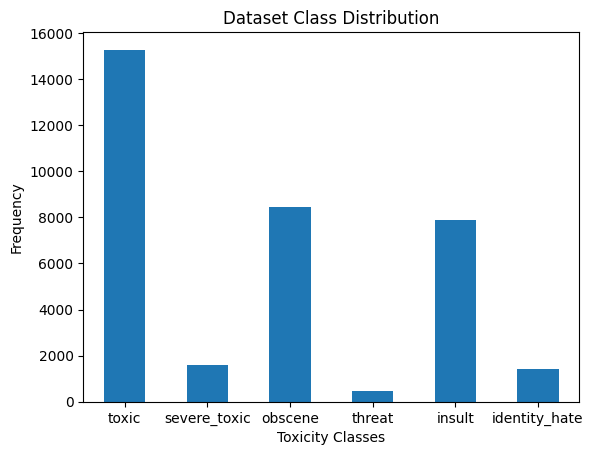

In [ ]:
df = pd.read_csv(drive_path+"/train.csv")

x_train = list(df['comment_text'].reset_index(drop=True))

y_data = df.iloc[:, -6:].reset_index(drop=True)

column_labels = list(y_data.columns)
print(column_labels)

# display(y_data)

y_columns = list(df.columns)

# draw bar graph to visualise the data distribution
freqs = y_data.sum()

freqs.plot(kind='bar', rot=0)
plt.title('Dataset Class Distribution')
plt.xlabel('Toxicity Classes')
plt.ylabel('Frequency')
plt.show()


## Obtain embeddings from SentenceTransformer

The SentenceTransformer library is specifically designed for creating sentence embeddings. It has several pre-trained models that have been trained on a diverse dataset which is highly beneficial, since it allows for the creation of generalizable embeddings.

all-MiniLM-L6-v2 maps sentences & paragraphs to a 384 dimensional dense vector space and it is designed to be used for tasks like clustering or semantic search.

In [ ]:
# Choosing the sentence embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')


In [ ]:
# x_train_embeddings = embedding_model.encode(x_train)

## Undersample data with 0 Class for training

Since 90% of the dataset contains the 0 class, training the model on the entire dataset will not be a fruitful exercise. Instead, we will undersample the non-toxic class to match the toxic class in our dataset.

Ideally, we would want every class in the dataset to have equal representation, however given the extremely low presence of the 3 minority classes, undersampling every class to the level of 500 datapoints would leave us with very less data, therefore, it won't be possible to train a model that could be generalized on real-world data.

Therefore, we strike a balance between the non-toxic and toxic class. This allows us to build a model that is able to generalize when dealing with toxic/non-toxic class. It also detects other specialized classes, however, due to the lack of training data for those classes, the model probably won't be able to generalize as well on those classes.



## Reshape x_train, add additional dimension for LSTM

The LSTM architecture expects the input data to be in the form of a 3d tensor.

In [ ]:

y_data = y_undersampled
x_train_reshaped = np.reshape(x_undersampled, (x_undersampled.shape[0], 1, x_undersampled.shape[1]))
print("x_train_reshaped:",x_train_reshaped.shape)
print("y_data.shape:",y_data.shape)


x_train_reshaped: (26450, 1, 384)
y_data.shape: (26450, 6)


## Split Data into 3 sets

Splitting the data in an 80/10/10 ratio.

The Validation data will be used to keep a check on the models performance during trained.

The train data is used later for evaluation once the training process has completed.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(x_train_reshaped, y_data, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Shapes:")
print("X Train:", X_train.shape)
print("y Train:", y_train.shape)
print("X Test:", X_test.shape)
print("y Test:", y_test.shape)
print("X Val:", X_val.shape)
print("y Val:", y_val.shape)



Shapes:
X Train: (21160, 1, 384)
y Train: (21160, 6)
X Test: (2645, 1, 384)
y Test: (2645, 6)
X Val: (2645, 1, 384)
y Val: (2645, 6)


## Analyze the distribution of classes after undersampling

Data belonging to 0 class is now almost 38% of the entire dataset. Data belonging to the toxic class has a slightly higher frequency, however, the instances of the other labels still remain significantly low.

8160
Total Train Data Points:  21160
Percentage of 0 class in train data: 38.56%
data left  =  13000
[12242, 1280, 6776, 382, 6343, 1142]


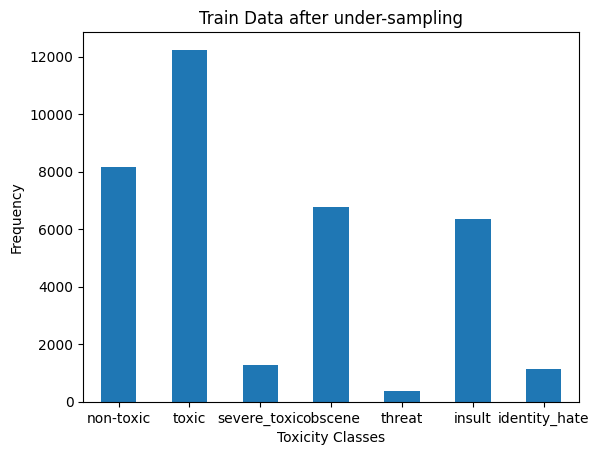

In [ ]:
counterzero = 0
counter_total = [0 ,0 ,0 ,0 ,0 ,0]

y_train_df = pd.DataFrame(y_train, columns=column_labels)

# print(type(y_train_df))

for index, row in y_train_df.iterrows():
    if row[0] == 0 and row[1] == 0 and row[2] == 0 and row[3] == 0 and row[4] == 0 and row[5] == 0:
        counterzero +=1
    if row[0] == 1:
        counter_total[0] +=1
    if row[1] == 1:
        counter_total[1] +=1
    if row[2] == 1:
        counter_total[2] +=1
    if row[3] == 1:
        counter_total[3] +=1
    if row[4] == 1:
        counter_total[4] +=1
    if row[5] == 1:
        counter_total[5] +=1


print(counterzero)
print("Total Train Data Points: ",X_train.shape[0])
print(f"Percentage of 0 class in train data: {100*float(counterzero)/X_train.shape[0]:.2f}%")
print("data left  = " ,  X_train.shape[0]- counterzero)
print(counter_total)

train_freqs = y_train_df.sum()
zero_df = pd.Series([counterzero], index=['non-toxic'])
train_freqs = pd.concat([zero_df, train_freqs])

train_freqs.plot(kind='bar', rot=0)
plt.title('Train Data after under-sampling')
plt.xlabel('Toxicity Classes')
plt.ylabel('Frequency')
plt.show()